In [1]:
import non_dim_lderiv_control as ld
import copy
import gym
import numpy as np
import pandas as pd
import scipy.integrate as si
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import CheckpointCallback

In [2]:
lmin = 0.9
lmax = 1.1
phi_0 = np.pi / 8
phidot_0 = 0
tau = 0.25  # (lmax - lmin) / 4
ldot_max = 0.25
power_max = 0.25

best working: 

lmin = 4.5, lmax = 5.5. u_max = .7,  $\theta_0 = \pi/9$

lmin = 0.8, lmax = 1.2, u_max = .25, $\theta_0 = \pi/9$, $\tau = 0.25$ <- no power bound

lmin = 0.8, lmax = 1.2, u_max = 0.5, $\theta_0 = \pi/16$, $\tau = 0.25$ <- with power bound. gets it halfway right

In [3]:
env = ld.Swing()
env.ldot_max = ldot_max
env.lmin = lmin
env.lmax = lmax
env.ldot_max = ldot_max
env.phi_0 = phi_0
env.phidot_0 = phidot_0
env.tau = tau
env.power_max = power_max

/Users/iandavenport/opt/anaconda3/lib/python3.7/site-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


In [4]:
checkpoint_callback = CheckpointCallback(
    save_freq=25_000,
    save_path="./w_power_logs/",
    name_prefix="rl_model",
)

In [5]:
# model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="tb_logs/")
model = SAC("MlpPolicy", env, verbose=1, tensorboard_log="tb_logs/")
# model = SAC.load("w_power_logs/rl_model_150000_steps.zip", env=env)
# model.save("logs/rl_model_0_steps")
model.learn(total_timesteps=3e5, callback=checkpoint_callback)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to tb_logs/SAC_9
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 3.77e+03  |
|    ep_rew_mean     | -3.77e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 63        |
|    time_elapsed    | 239       |
|    total_timesteps | 15086     |
| train/             |           |
|    actor_loss      | 46.1      |
|    critic_loss     | 0.0437    |
|    ent_coef        | 0.0135    |
|    ent_coef_loss   | -2.54     |
|    learning_rate   | 0.0003    |
|    n_updates       | 14985     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2.93e+03  |
|    ep_rew_mean     | -2.93e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 63        |
|    time_elapsed    | 370       |
|    t

In [6]:
env = ld.Swing()
env.ldot_max = ldot_max
env.lmin = lmin
env.lmax = lmax
env.ldot_max = ldot_max
env.phi_0 = phi_0
env.phidot_0 = phidot_0
env.power_max = power_max
env.tau = tau / 500
env.pump_limit = 200e3
model = SAC.load("w_power_logs/rl_model_300000_steps", env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [7]:
done = False
obs = env.reset()
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, _ = env.step(action)

phi_hist = np.array(env.phi)
l_hist = np.array(env.L)

x_t = l_hist * np.sin(phi_hist)
y_t = -l_hist * np.cos(phi_hist)
ref_x = np.array(env.lmax) * np.sin(env.phi)
ref_y = -np.array(env.lmax) * np.cos(env.phi)

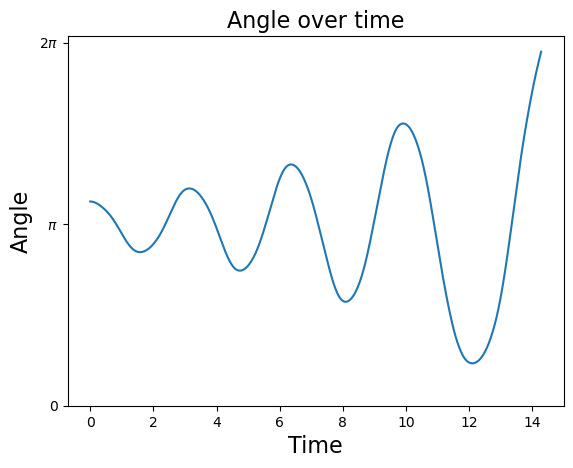

In [8]:
fontdict = {"fontsize": 16}
plt.plot(
    env.tau / 2 * np.arange(len(env.phi)), np.mod(np.array(env.phi) + np.pi, 2 * np.pi)
)
plt.yticks([0, np.pi, 2 * np.pi], ["0", r"$\pi$", r"2$\pi$"])
plt.xlabel("Time", fontdict=fontdict)
plt.ylabel("Angle", fontdict=fontdict)
plt.title("Angle over time", fontdict=fontdict)
plt.savefig("theta.png")

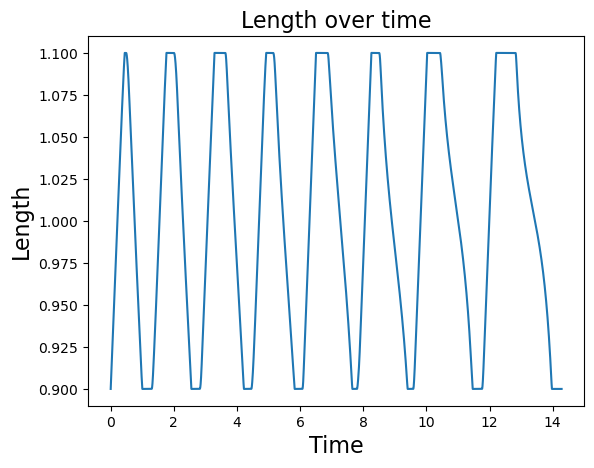

In [9]:
plt.plot(env.tau / 2 * np.arange(len(env.phi)), env.L)
plt.xlabel("Time", fontdict=fontdict)
plt.ylabel("Length", fontdict=fontdict)
plt.title("Length over time", fontdict=fontdict)
plt.savefig("length.png")
plt.show()

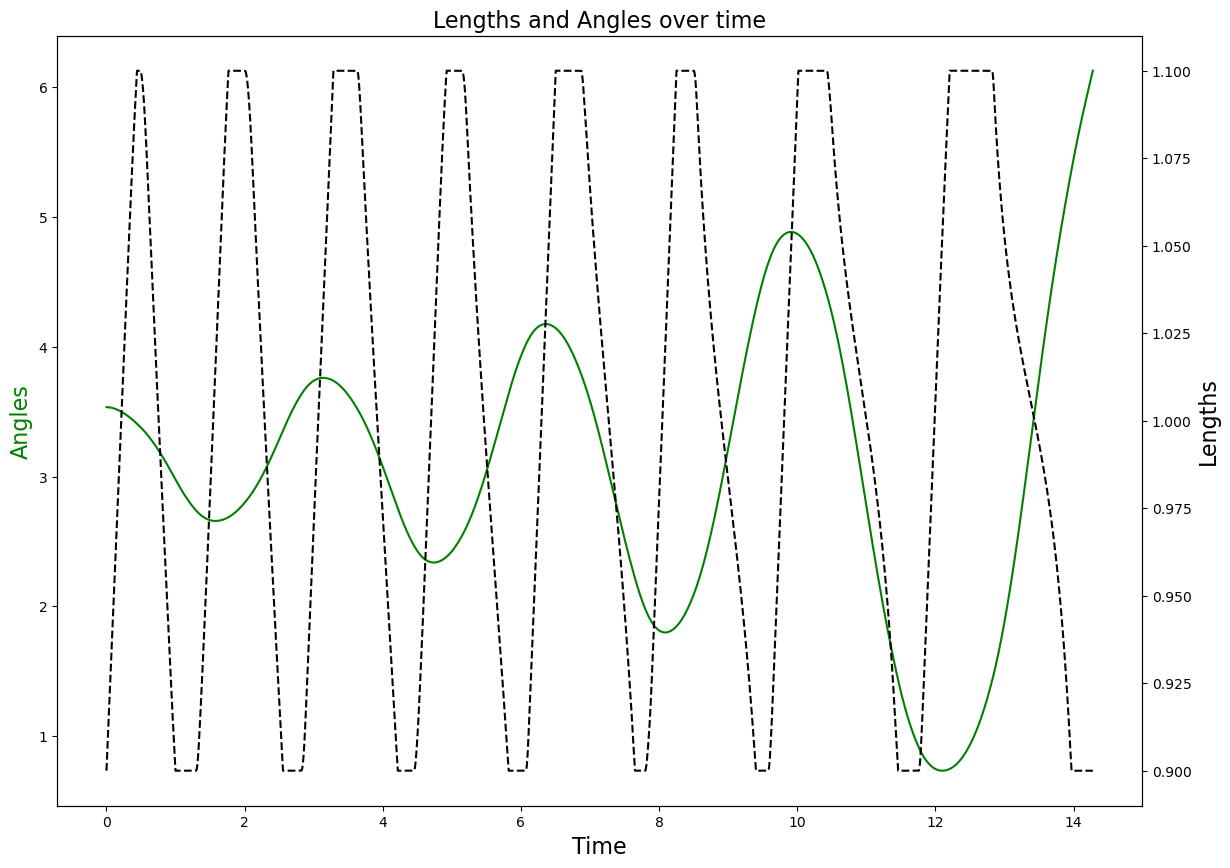

In [10]:
fig, ax1 = plt.subplots(figsize=(14, 10))

ax2 = ax1.twinx()
ax1.plot(
    env.tau / 2 * np.arange(len(env.phi)),
    np.mod(np.array(env.phi) + np.pi, 2 * np.pi),
    "g-",
)
ax2.plot(env.tau / 2 * np.arange(len(env.phi)), env.L, "k--")

ax1.set_xlabel("Time", fontsize=16)
ax1.set_ylabel("Angles", color="g", fontsize=16)
ax2.set_ylabel("Lengths", color="k", fontsize=16)

plt.title("Lengths and Angles over time", fontsize=16)
plt.savefig("overlay.png")

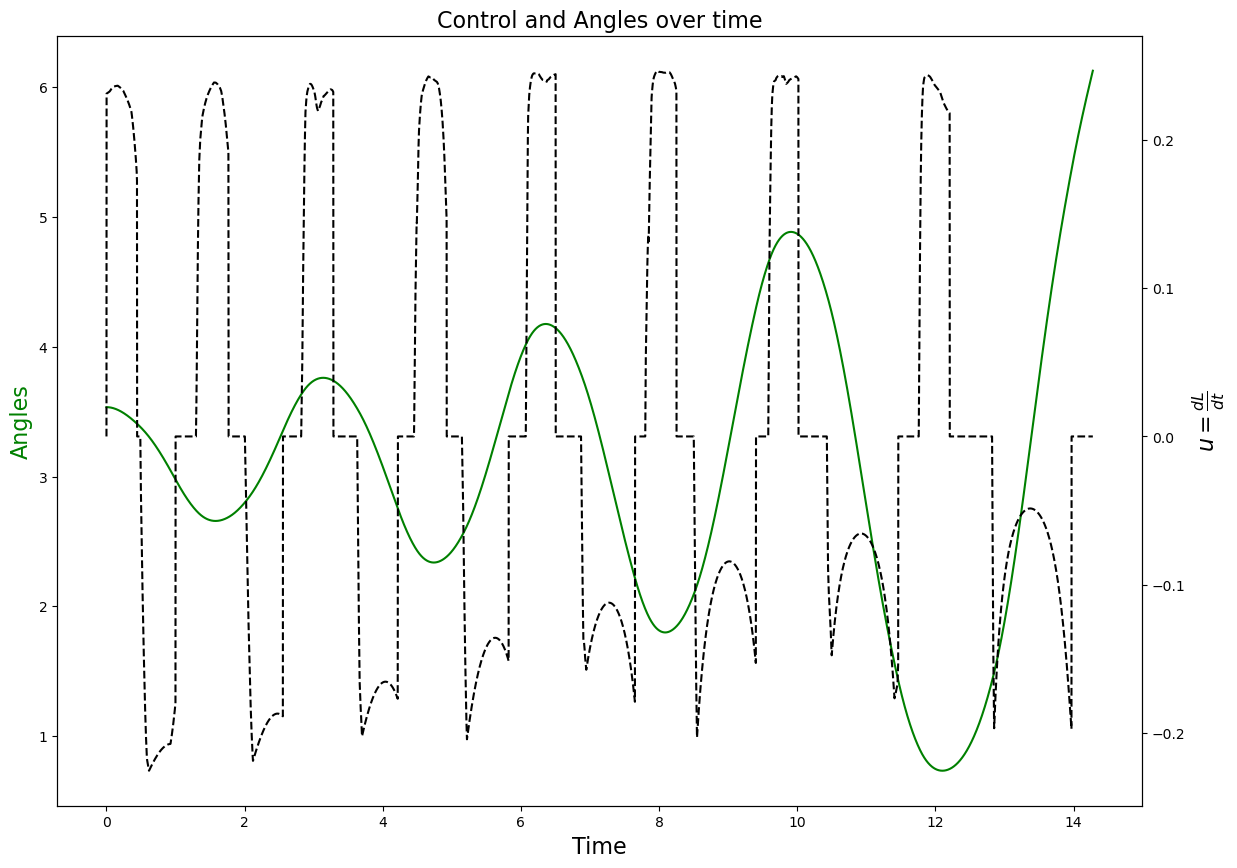

In [11]:
fig, ax1 = plt.subplots(figsize=(14, 10))

ax2 = ax1.twinx()
ax1.plot(
    env.tau / 2 * np.arange(len(env.phi))[:-1],
    np.mod(np.array(env.phi) + np.pi, 2 * np.pi)[:-1],
    "g-",
)
ax2.plot(env.tau * np.arange(len(env.Ldot_hist))[:-1] / 2, env.Ldot_hist[:-1], "k--")

ax1.set_xlabel("Time", fontsize=16)
ax1.set_ylabel("Angles", color="g", fontsize=16)
ax2.set_ylabel(r"$u = \frac{dL}{dt}$", color="k", fontsize=16)

plt.title("Control and Angles over time", fontsize=16)
plt.savefig("control_overlay.png")

In [12]:
t = env.tau / 2 * np.arange(len(env.phi))[:-1]
phi = np.mod(np.array(env.phi) + np.pi, 2 * np.pi)[:-1]
l_dot_hist_t = env.tau * np.arange(len(env.Ldot_hist))[:-1]
l_dot_hist = env.Ldot_hist[:-1]
smooth_angle = savgol_filter(phi, 9, 2)

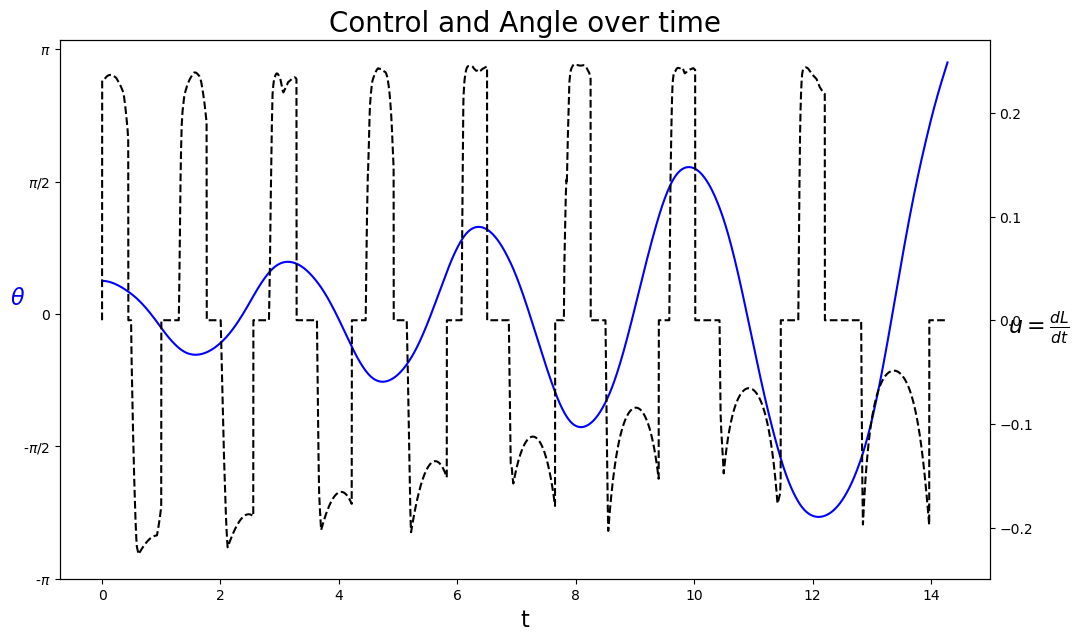

In [13]:
fig, ax1 = plt.subplots(figsize=(12, 7))

ax2 = ax1.twinx()
ax1.plot(t[:], smooth_angle[:] - np.pi, "b")
ax2.plot(l_dot_hist_t / 2, l_dot_hist, "k--")

ax1.set_xlabel("t", fontsize=16)
ax1.set_ylabel(r"$\theta$", fontsize=16, color="b", rotation=0)
ax1.set_yticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi])
ax1.set_yticklabels([r"-$\pi$", "-$\pi/2$", "0", "$\pi/2$", r"$\pi$"])
ax2.set_ylabel(r"$u = \frac{dL}{dt}$", color="k", fontsize=16, rotation=0)

plt.title("Control and Angle over time", fontsize=20)
# plt.show()
plt.savefig("control_overlay.png")

In [14]:
control_dict = {"time": l_dot_hist_t / 2, "control": l_dot_hist}
angle_dict = {"time": t, "angle": phi - np.pi}

In [15]:
ang_df = pd.DataFrame(angle_dict)
ctrl_df = pd.DataFrame(control_dict)

In [16]:
ang_df.to_csv("power_limit_angle.csv")
ctrl_df.to_csv("power_limit_control.csv")